In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *


df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
filters = ['ztfg', 'ztfr', 'ztfi']


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,...,abs_mag_ztfi,mag_error_ztfi,flux_ztfg,flux_error_ztfg,flux_ztfr,flux_error_ztfr,flux_ztfi,flux_error_ztfi,rise,fade
0,ZTF18aakuewf,Ibn,0.0636,58226.340532,58226.340532,0.000000,18.516426,-13.834339,0.235213,18.914558,...,NaN,NaN,142.373588,30.843697,98.668109,1.246373,NaN,NaN,y,y
1,ZTF18aakuewf,Ibn,0.0636,58226.390513,58226.340532,0.049981,18.496472,-13.854294,0.224712,18.882957,...,NaN,NaN,145.014457,30.013242,101.582057,1.080243,NaN,NaN,y,y
2,ZTF18aakuewf,Ibn,0.0636,58226.440494,58226.340532,0.099961,18.476866,-13.873900,0.214622,18.852310,...,NaN,NaN,147.656847,29.187955,104.490322,1.080575,NaN,NaN,y,y
3,ZTF18aakuewf,Ibn,0.0636,58226.490474,58226.340532,0.149942,18.457598,-13.893168,0.204923,18.822692,...,NaN,NaN,150.300692,28.367979,107.379974,1.219787,NaN,NaN,y,y
4,ZTF18aakuewf,Ibn,0.0636,58226.540455,58226.340532,0.199923,18.438655,-13.912110,0.195597,18.794102,...,NaN,NaN,152.945927,27.553467,110.245034,1.433721,NaN,NaN,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36853,ZTF24aascytf,II,0.0380,60480.172223,60476.217836,3.954388,20.793887,-10.398977,NaN,20.312205,...,-11.090834,0.700057,17.476125,16.519709,27.234410,15.860492,33.051259,21.310669,y,y
36854,ZTF24aascytf,II,0.0380,60480.181356,60476.217836,3.963520,20.795950,-10.396914,NaN,20.315167,...,-11.087963,0.703241,17.442947,16.623801,27.160225,15.918773,32.963971,21.351059,y,y
36855,ZTF24aascytf,II,0.0380,60480.190488,60476.217836,3.972653,20.797930,-10.394934,NaN,20.318076,...,-11.085116,0.706375,17.411165,16.725866,27.087546,15.974491,32.877653,21.390053,y,y
36856,ZTF24aascytf,II,0.0380,60480.199621,60476.217836,3.981785,20.799828,-10.393036,NaN,20.320933,...,-11.082294,0.709458,17.380760,16.825905,27.016360,16.027639,32.792302,21.427639,y,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,ZTF18aakuewf,Ibn,0.0636,58226.340532,58226.340532,0.000000,NaN,NaN,NaN,18.961000,-13.389765,0.031726,NaN,NaN,NaN
1,ZTF18aakuewf,Ibn,0.0636,58226.358623,58226.340532,0.018090,NaN,NaN,NaN,18.871901,-13.478865,0.029414,NaN,NaN,NaN
2,ZTF18aakuewf,Ibn,0.0636,58226.378947,58226.340532,0.038414,NaN,NaN,NaN,18.922800,-13.427966,0.033493,NaN,NaN,NaN
3,ZTF18aakuewf,Ibn,0.0636,58226.414456,58226.340532,0.073924,NaN,NaN,NaN,18.856501,-13.494265,0.031619,NaN,NaN,NaN
4,ZTF18aakuewf,Ibn,0.0636,58226.415394,58226.340532,0.074861,NaN,NaN,NaN,18.849501,-13.501265,0.033379,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,ZTF24aascytf,II,0.038,60479.408218,60476.217836,3.190382,20.327264,-10.8656,0.156657,NaN,NaN,NaN,NaN,NaN,NaN
5850,ZTF24aascytf,II,0.038,60481.354132,60476.217836,5.136296,NaN,NaN,NaN,20.379625,-10.813239,0.187584,NaN,NaN,NaN
5851,ZTF24aascytf,II,0.038,60485.341238,60476.217836,9.123403,NaN,NaN,NaN,20.009301,-11.183563,0.197632,NaN,NaN,NaN
5852,ZTF24aascytf,II,0.038,60485.341238,60476.217836,9.123403,NaN,NaN,NaN,20.009281,-11.183583,0.197632,NaN,NaN,NaN


In [3]:
df_rates = pd.read_csv('gp_objects_rates.csv')
df_2019 = pd.read_csv('bulla_2019_rates.csv')
display(df_rates)
display(df_2019)

,obj_id,type,redshift,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,...,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_rg_color,ztfr_peak_ri_color,ztfi_peak_ig_color,ztfi_peak_ir_color
0,ZTF18aakuewf,Ibn,0.063600,3.898491,-0.212266,4.198375,-0.263955,NaN,NaN,1.999226,...,4.198375,-14.544391,NaN,NaN,-0.125221,NaN,0.114833,NaN,NaN,NaN
1,ZTF18aalrxas,IIb,0.058200,1.961364,-0.347913,2.059432,-0.255482,NaN,NaN,1.961364,...,2.059432,-12.955816,NaN,NaN,-0.285940,NaN,0.281758,NaN,NaN,NaN
2,ZTF18abffyqp,II,0.031000,0.950871,-0.022003,2.502293,-0.051005,NaN,NaN,1.951789,...,2.502293,-12.327379,NaN,NaN,-0.266498,NaN,0.142349,NaN,NaN,NaN
3,ZTF18abvkmgw,Ib,0.038470,4.277578,-0.375830,4.730358,-0.339628,NaN,NaN,1.989848,...,4.730358,-12.389784,NaN,NaN,-0.003031,NaN,-0.018309,NaN,NaN,NaN
4,ZTF18abwkrbl,IIb,0.009990,2.837926,-0.682061,3.620802,-0.485527,NaN,NaN,1.957190,...,3.620802,-12.221934,NaN,NaN,-0.092534,NaN,0.041934,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,ZTF23aarlxdf,Novae;Classical Nova,-0.001000,NaN,NaN,NaN,NaN,NaN,NaN,1.986957,...,0.000000,16.812194,0.0,17.296574,-0.224443,-0.708822,0.224443,-0.484380,0.708822,0.484380
65,ZTF23aaxeacr,afterglow; Ic-BL,0.360000,NaN,NaN,NaN,NaN,NaN,NaN,0.170266,...,0.000000,-17.596908,NaN,NaN,0.236294,NaN,-0.236294,NaN,NaN,NaN
66,ZTF23aaxzvrr,Novae;Classical Nova,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.999967,...,0.000000,17.137527,0.0,17.216648,0.104927,0.025807,-0.104927,-0.079121,-0.025807,0.079121
67,ZTF23abobwsd,IIb,0.024000,NaN,NaN,NaN,NaN,NaN,NaN,1.978073,...,0.000000,-12.180304,0.0,-12.100538,0.071736,-0.008030,-0.071736,-0.079765,0.008030,0.079765


,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,ztfr_fade_rate,ztfi_peak_mag,ztfi_peak_time,ztfi_rise_rate,ztfi_fade_rate,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_rg_color,ztfr_peak_ri_color,ztfi_peak_ig_color,ztfi_peak_ir_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,-15.659,0.5,NaN,0.988000,-15.706,0.5,NaN,0.728000,-0.856,0.047,-0.856,0.047,-0.903,-0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,-15.582,0.5,NaN,0.968000,-15.633,0.5,NaN,0.721333,-0.852,0.051,-0.852,0.051,-0.903,-0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,-15.505,0.5,NaN,0.946667,-15.565,0.5,NaN,0.718667,-0.850,0.060,-0.850,0.060,-0.910,-0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,-15.429,0.5,NaN,0.927333,-15.491,0.5,NaN,0.711333,-0.851,0.062,-0.851,0.062,-0.913,-0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,-15.355,0.5,NaN,0.907333,-15.417,0.5,NaN,0.704000,-0.854,0.062,-0.854,0.062,-0.916,-0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,-13.853,3.0,-0.7204,0.007333,-14.368,3.5,-0.699667,0.017333,-0.837,0.512,-0.837,0.512,-1.380,-0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,-13.845,3.0,-0.7248,0.010000,-14.367,3.5,-0.700000,0.022667,-0.831,0.515,-0.831,0.515,-1.389,-0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,-13.841,3.0,-0.7208,0.010667,-14.359,3.5,-0.701000,0.018667,-0.828,0.514,-0.828,0.514,-1.386,-0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,-13.841,3.0,-0.7120,0.010667,-14.355,3.5,-0.696667,0.020000,-0.833,0.513,-0.833,0.513,-1.384,-0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


In [4]:
types = df['type'].unique()
print('number of types:', len(types))
colors = sns.color_palette("husl", len(types))
colors_dict = {types[i]: colors[i] for i in range(len(types))}
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.']
type_style_dict = {types[i]: {'color': colors[i], 'marker': markers[i]} for i in range(len(types))}

number of types: 18


/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_20717/1209955332.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rates, x='type', order=sorted_types, palette=colors_dict, ax=ax)
/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_20717/1209955332.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


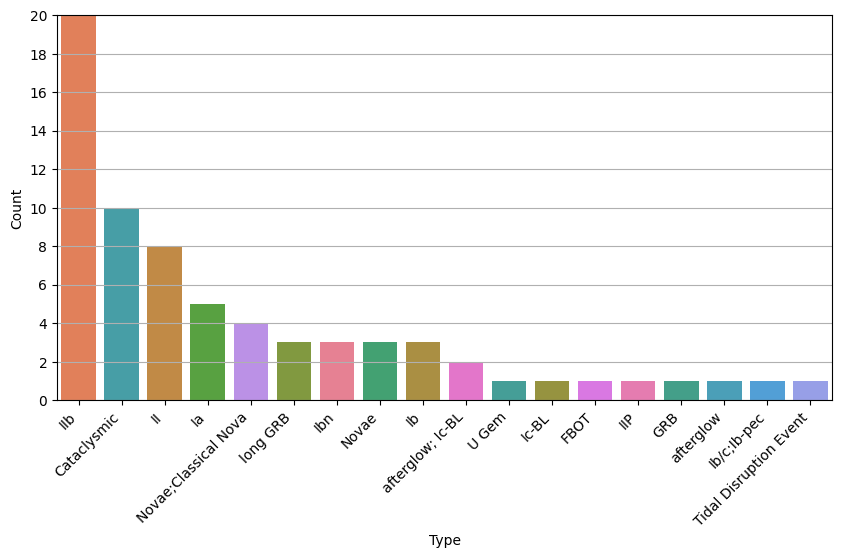

In [5]:
from matplotlib.ticker import MaxNLocator
type_counts = df_rates['type'].value_counts()
sorted_types = type_counts.index
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(axis='y')
sns.countplot(data=df_rates, x='type', order=sorted_types, palette=colors_dict, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(0,20)
# plt.savefig('figures/type_distribution.pdf', bbox_inches='tight')
plt.show()

Color at Peak

### Still need to do this since the color for the model grid has not been calculated yet

Rise vs Peak Magnitude

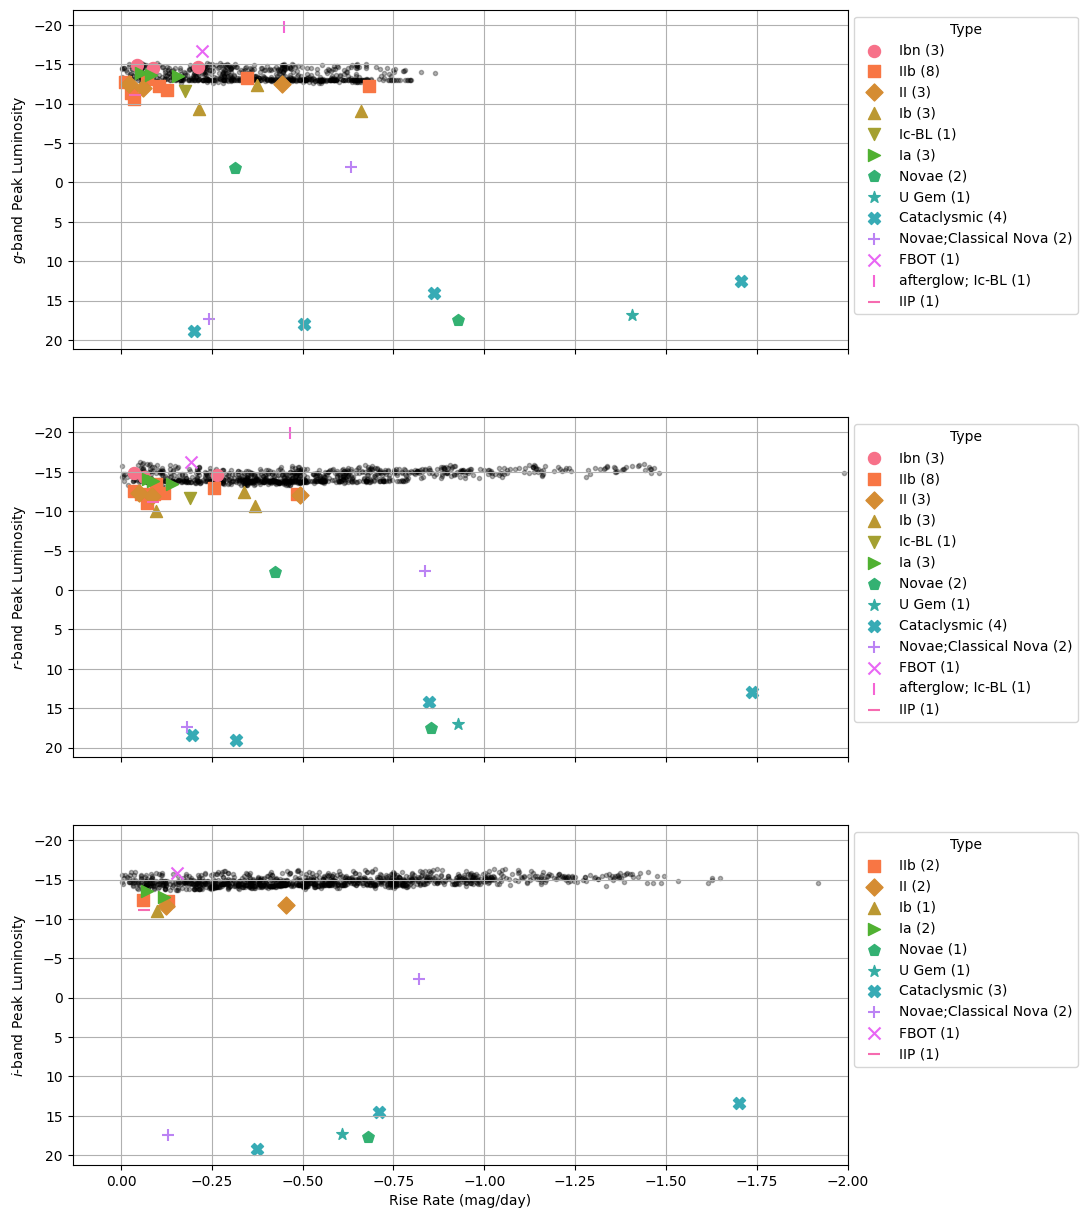

In [6]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True,sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
#plt.savefig('figures/rise_rate_vs_peak_luminosity.pdf', bbox_inches='tight')
plt.show()

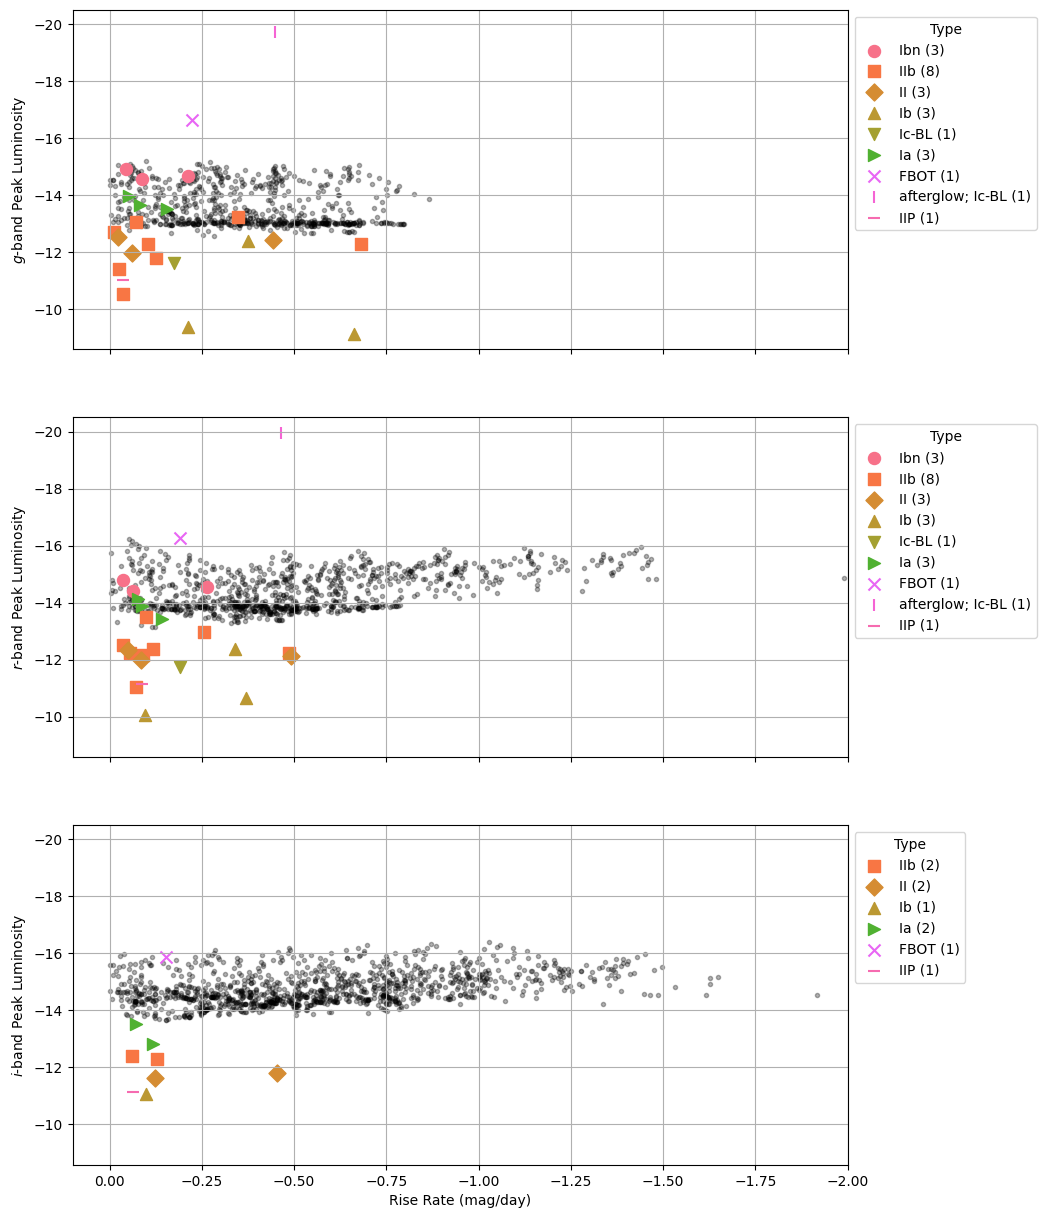

In [7]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates_far[df_rates_far['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
#plt.savefig('figures/rise_rate_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight')
plt.show()

Fade vs Peak Magnitude

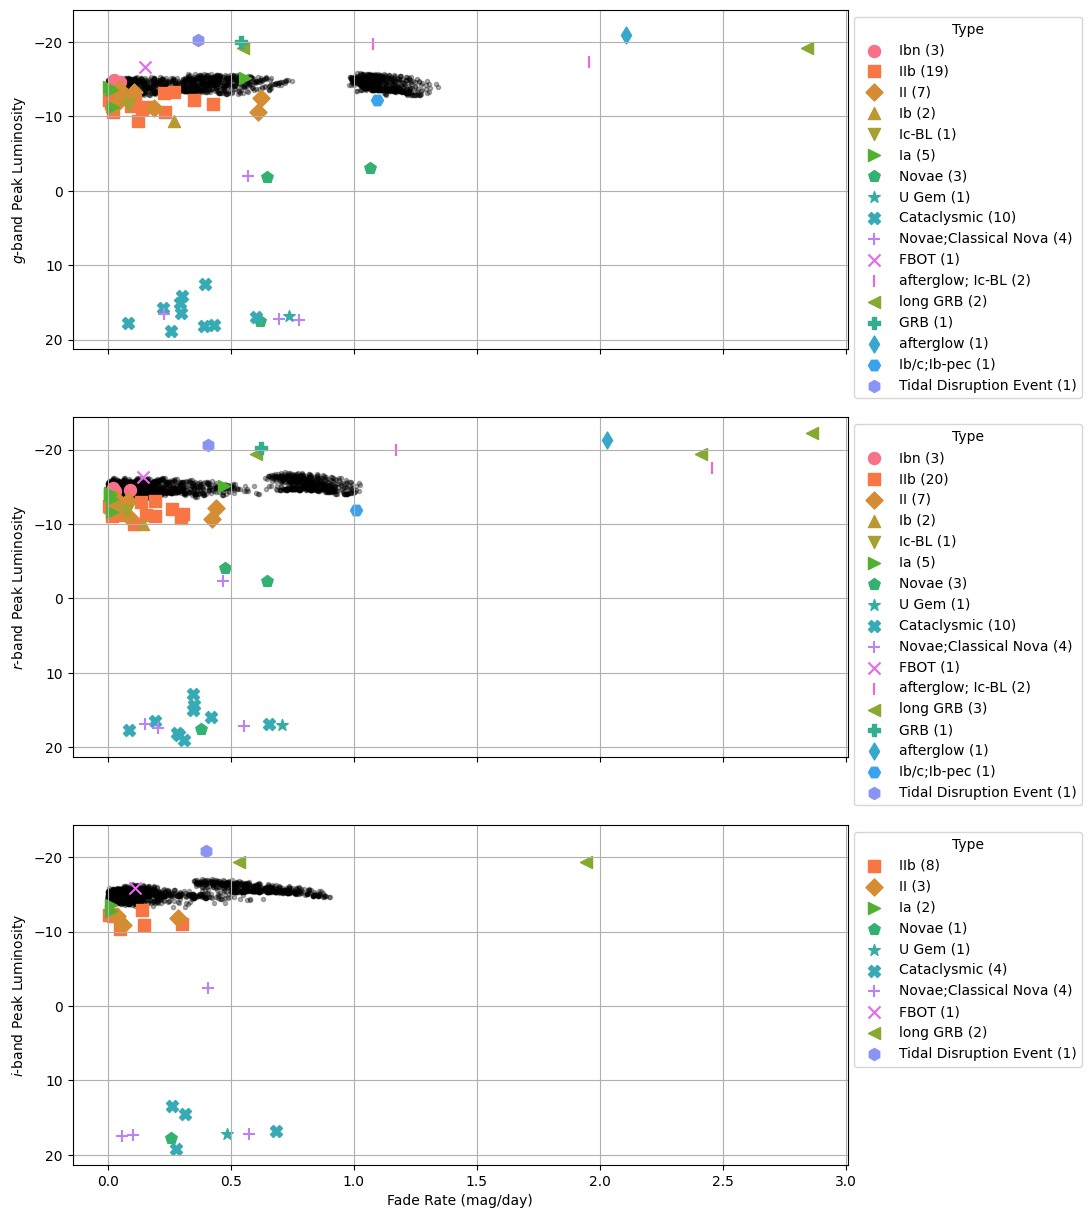

In [8]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True, sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fade_rate'] > 0)]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
#plt.savefig('figures/fade_rate_vs_peak_luminosity.pdf', bbox_inches='tight')
plt.show()

z > 0.001 objects

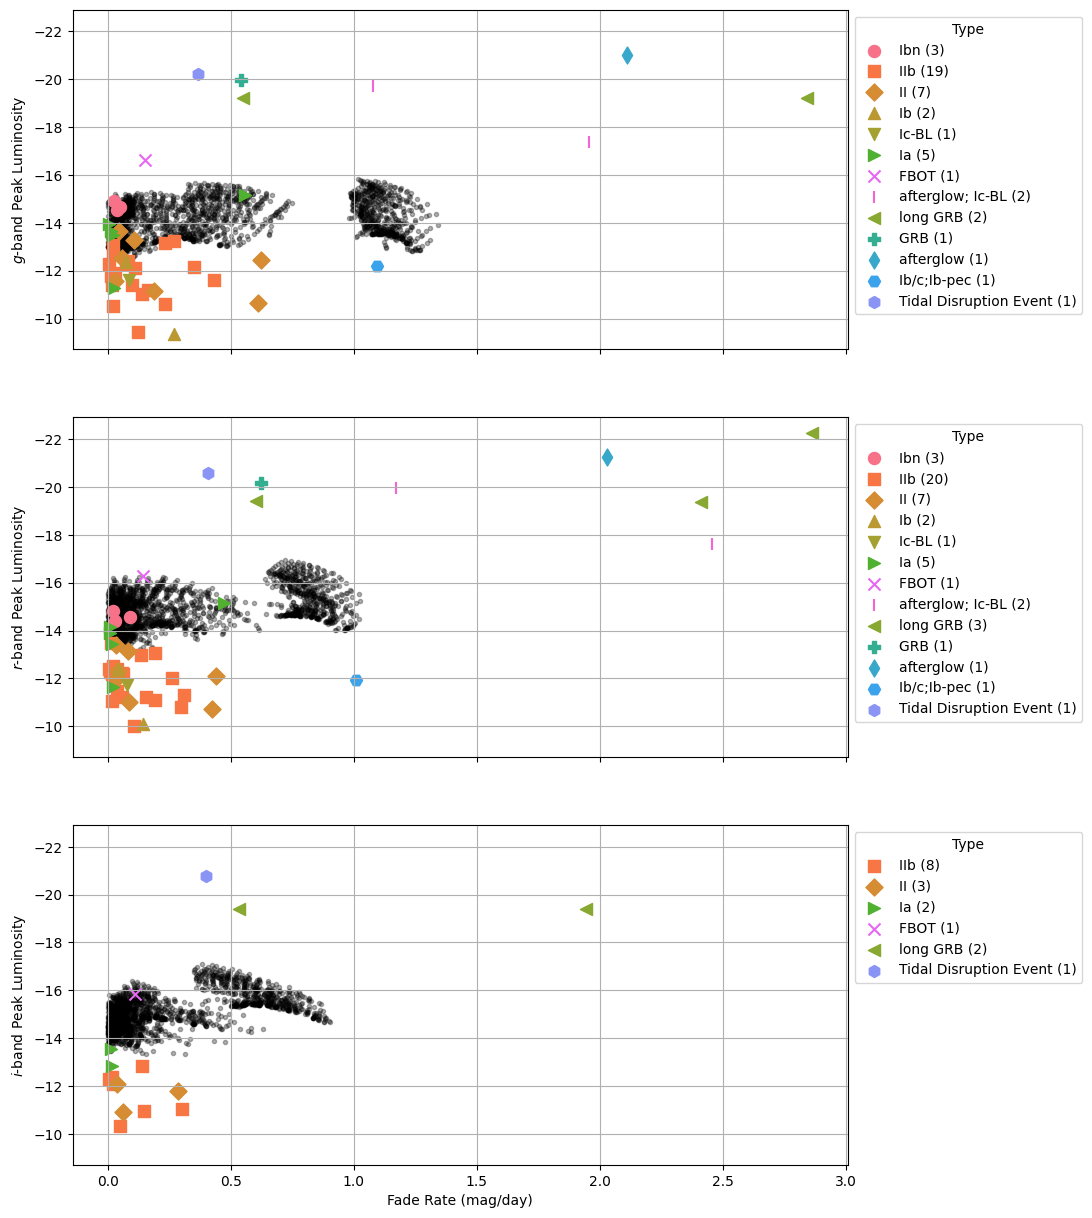

In [9]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull()) & (df_rates_far[f'{filter}_fade_rate'] > 0)]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_fade_rate', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_fade_rate', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates_far[df_rates_far['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
#plt.savefig('figures/fade_rate_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight')
plt.show()

Rise vs Fade

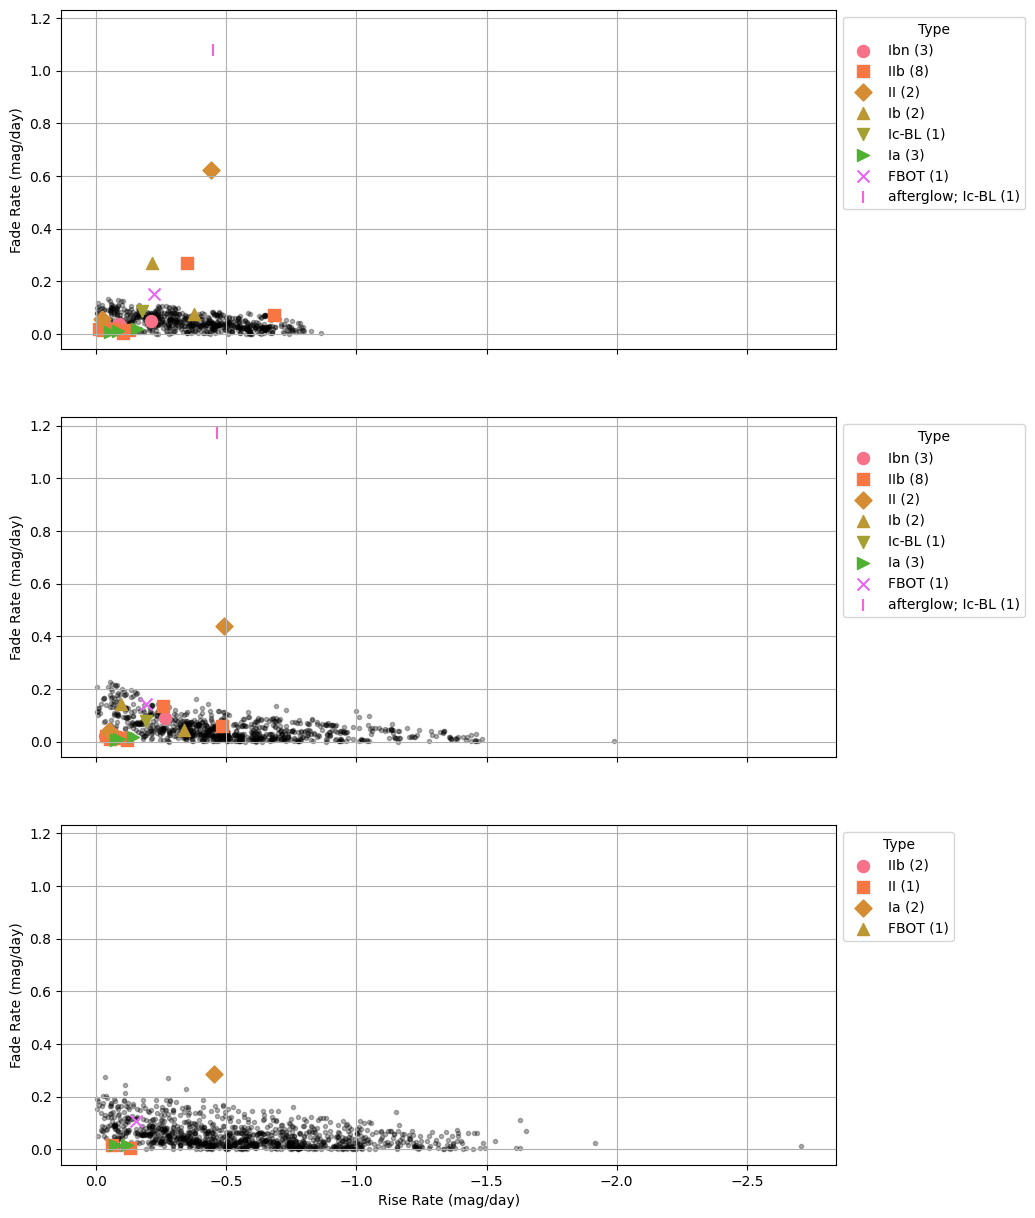

In [11]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_fade_rate'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_)]
        if len(df_class) > 0:
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_fade_rate'],
                            color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                             s=75, label=type_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', hue='type', style='type', s=150, ax=ax[axi])

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfg_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[(df_rates['ztfr_rise_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[(df_rates['ztfi_rise_rate'].notnull()) & (df_rates['ztfi_fade_rate'].notnull())]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("Fade Rate (mag/day)"), ax[1].set_ylabel("Fade Rate (mag/day)"), ax[2].set_ylabel("Fade Rate (mag/day)")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
#plt.savefig('figures/rise_rate_vs_fade_rate.pdf', bbox_inches='tight')
plt.show()

g-band rise vs r-band rise & g-band fade vs r-band fade

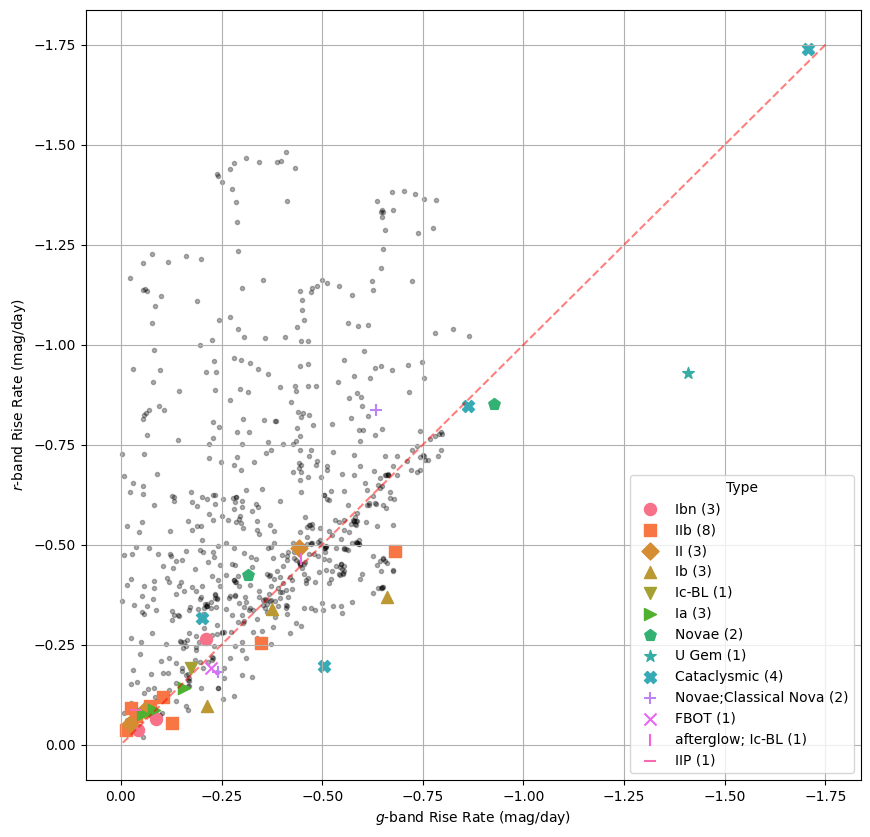

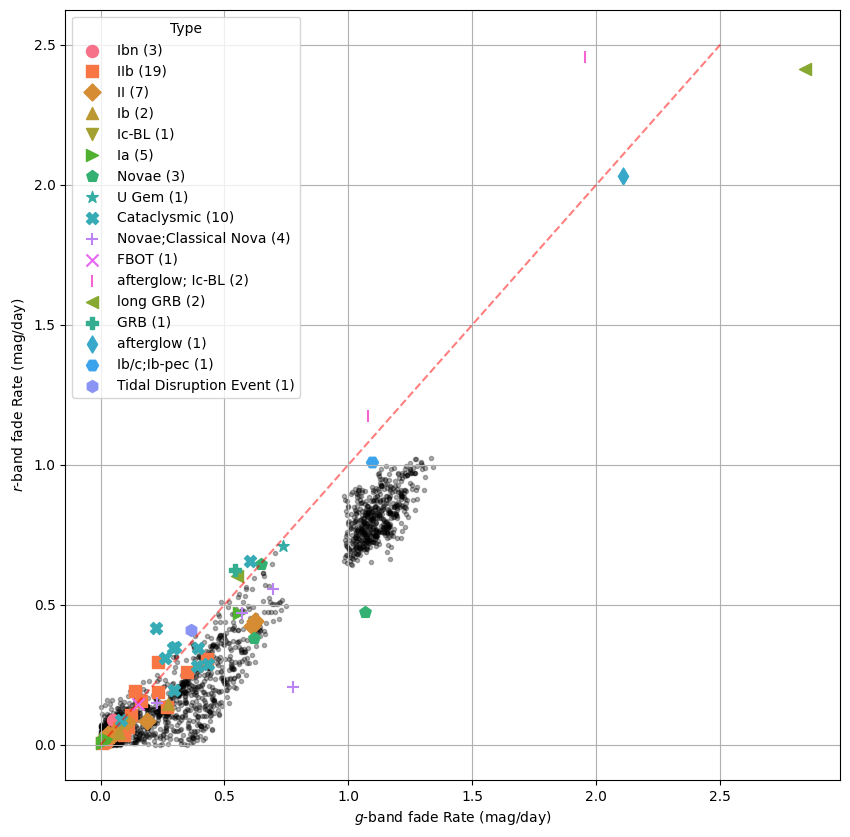

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfg_rise_rate'], df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfr_rise_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(-1.75,0,100), np.linspace(-1.75,0,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]
    if len(df_class) > 0:
        ax.scatter(df_class[f'ztfg_rise_rate'], df_class[f'ztfr_rise_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=75, label=type_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylabel("$\it{r}$-band Rise Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band Rise Rate (mag/day)");
#plt.savefig('figures/ztfg_rise_rate_vs_ztfr_rise_rate.pdf', bbox_inches='tight')
ax.invert_xaxis(), ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfg_fade_rate'], df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfr_fade_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]
    if len(df_class) > 0:
        ax.scatter(df_class[f'ztfg_fade_rate'], df_class[f'ztfr_fade_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=75, label=type_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylabel("$\it{r}$-band fade Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band fade Rate (mag/day)");
#plt.savefig('figures/ztfg_fade_rate_vs_ztfr_fade_rate.pdf', bbox_inches='tight')
#ax.invert_xaxis(), ax.invert_yaxis()
plt.show()

## Metric Distances Experiment

In [13]:
def metric_distance(object, model_data):
    '''
    Finds the average distance between an object and model data. 
    
    Args:
    object (tuple): tuple containing an object's two metrics (x,y)
    model_data (list): list of tuples containing the model data's metrics (x,y)
    
    Returns:
    distance (float): average distance between object and model_data
    '''
    distance_array = np.array([np.sqrt((object[0] - model[0])**2 + (object[1] - model[1])**2) for model in model_data])
    distance_array = distance_array[~np.isnan(distance_array)]
    # print(distance_array)
    distance = np.mean(distance_array)
    return distance


In [14]:
model_risepeak_list = list(zip(df_2019['ztfg_rise_rate'], df_2019['ztfg_peak_mag']))
objects_risepeak_list = list(zip(df_rates['ztfg_rise_rate'], df_rates['ztfg_peak_mag']))
# print(objects_risepeak_list)
# print(df_risepeak['obj_id'])
distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}

/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
for filt in ['ztfg', 'ztfr', 'ztfi']:
    model_risepeak_list = list(zip(df_2019[f'{filt}_rise_rate'], df_2019[f'{filt}_peak_mag']))
    objects_risepeak_list = list(zip(df_rates[f'{filt}_rise_rate'], df_rates[f'{filt}_peak_mag']))
    distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}
    df_rates[f'{filt}_risepeak_distance'] = distance_risepeak.values() 
    
    model_fadepeak_list = list(zip(df_2019[f'{filt}_fade_rate'], df_2019[f'{filt}_peak_mag']))
    objects_fadepeak_list = list(zip(df_rates[f'{filt}_fade_rate'], df_rates[f'{filt}_peak_mag']))
    distance_fadepeak = {obj: metric_distance(obj_data, model_fadepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_fadepeak_list)}
    df_rates[f'{filt}_fadepeak_distance'] = distance_fadepeak.values()

/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/nmma_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: 

<Axes: xlabel='ztfg_fadepeak_distance', ylabel='Count'>

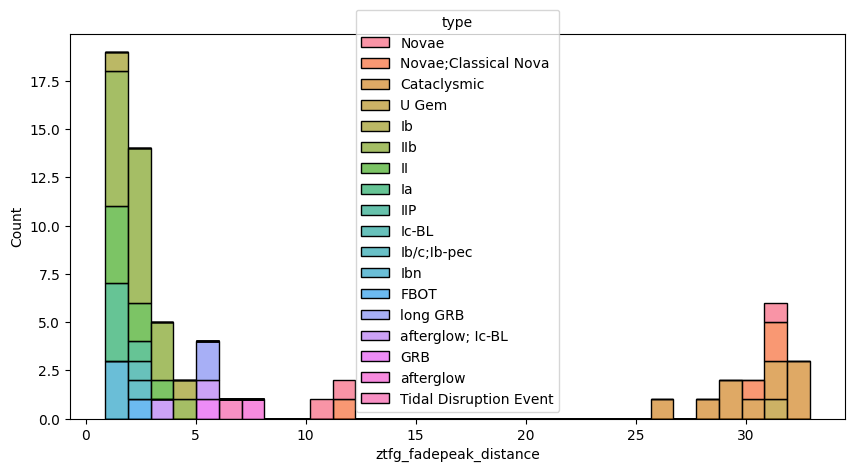

In [16]:
sns.set_palette('colorblind')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=df_rates.sort_values('redshift'), x='ztfg_fadepeak_distance', hue='type', multiple='stack', ax=ax, bins=31)

((-0.01, 0.25), (-0.05, 35.0))

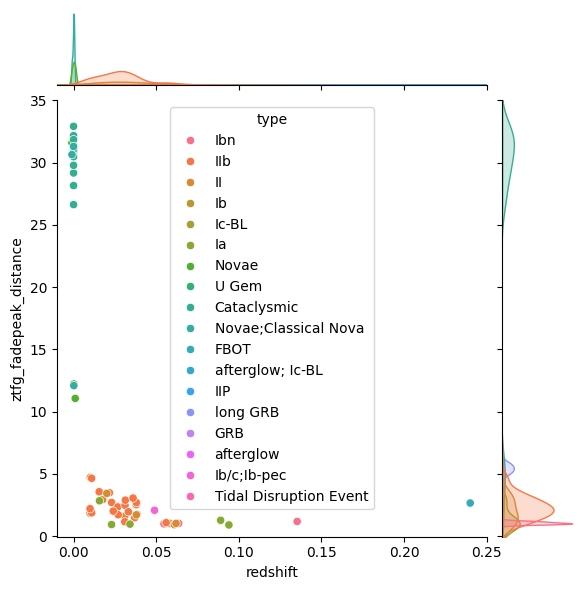

In [17]:
JG1 = sns.jointplot(data=df_rates, x='redshift', y='ztfg_fadepeak_distance', hue='type',markers='type')
JG1.ax_marg_x.set_xlim(-0.01,0.25), JG1.ax_marg_y.set_ylim(-0.05,35)
# JG1.ax_marg_x.set_xlim(-0.3,None), JG1.ax_marg_y.set_ylim(-1,None)

/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_20717/812252546.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


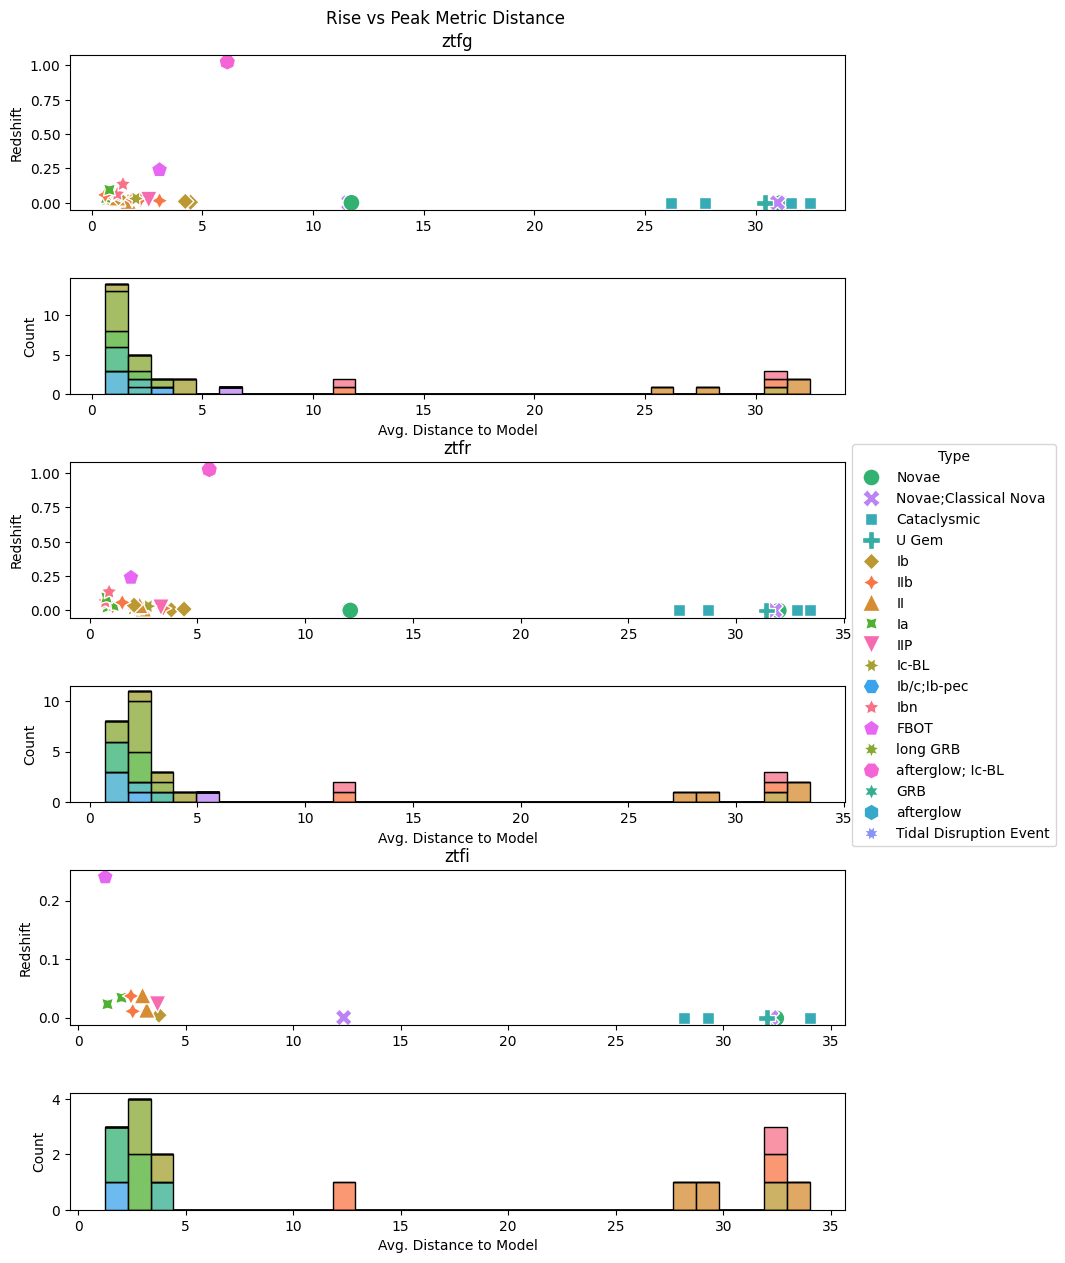

In [18]:
filters = ['ztfg', 'ztfr', 'ztfi'] 
y_column = 'redshift'
x_columns = {
    'ztfg': 'ztfg_risepeak_distance',
    'ztfr': 'ztfr_risepeak_distance',
    'ztfi': 'ztfi_risepeak_distance'
}

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

handles, labels = [], []

for i, filt in enumerate(filters):

    x_column = x_columns[filt]

    ax_scatter = fig.add_subplot(gs[i*2, 0])
    scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter, palette=colors_dict)
    ax_scatter.set_title(f'{filt}')
    ax_scatter.set_ylabel('Redshift')
    ax_scatter.set_xlabel(None)

    if i == 0:
        handles, labels = ax_scatter.get_legend_handles_labels()
    ax_scatter.legend_.remove()
    
    ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
    #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
    sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
    ax_hist.set_xlabel('Avg. Distance to Model')
    #ax_hist.set_ylabel('Count')

fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")
fig.suptitle('Rise vs Peak Metric Distance', y=0.91)
plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()

/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_20717/125871299.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


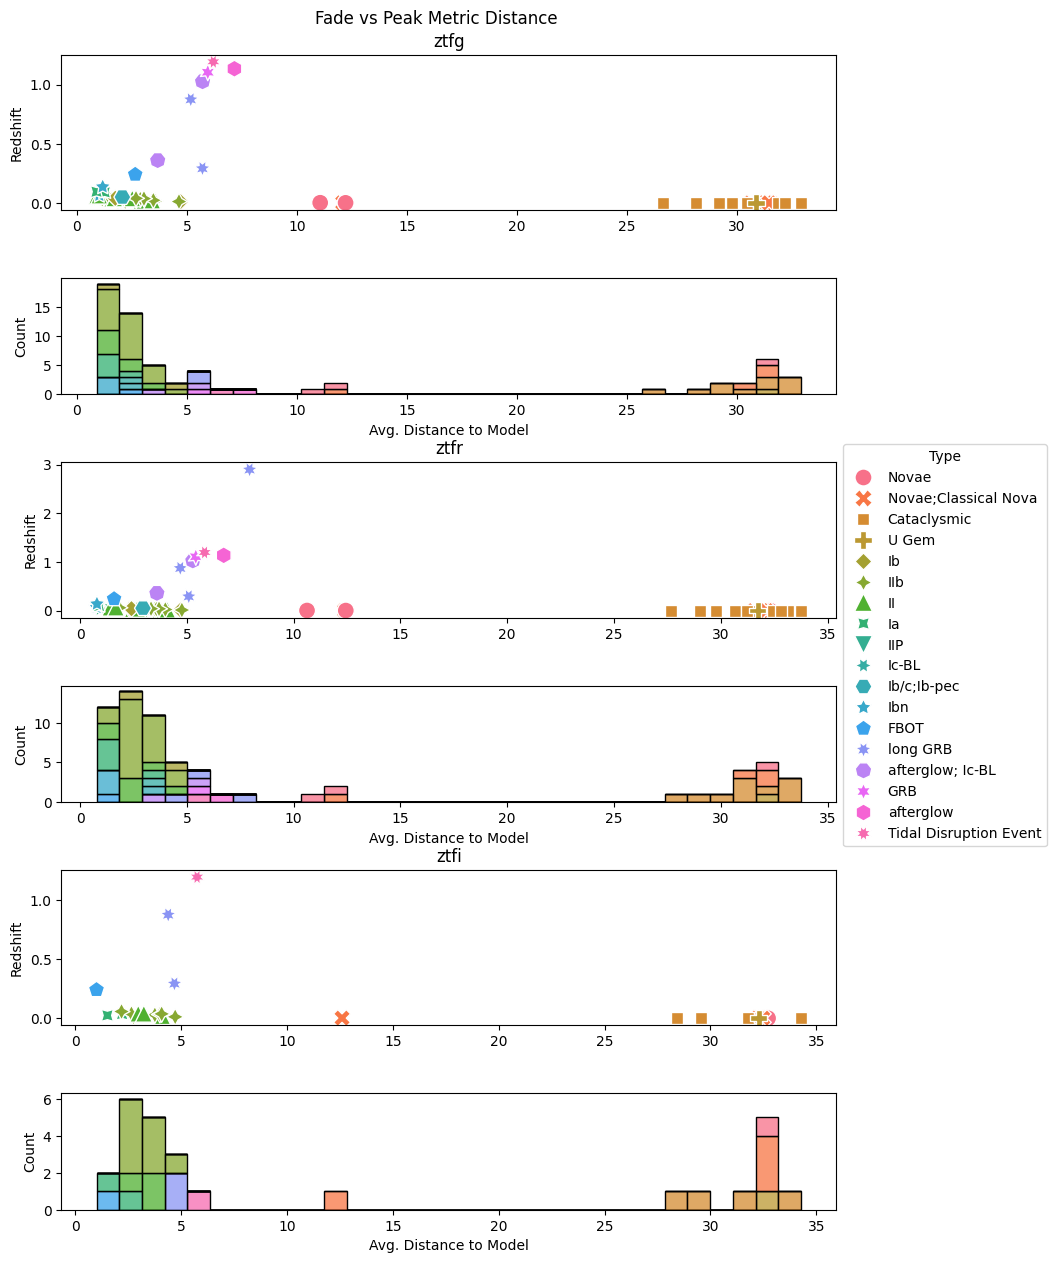

In [19]:
filters = ['ztfg', 'ztfr', 'ztfi'] 
y_column = 'redshift'
x_columns = {
    'ztfg': 'ztfg_fadepeak_distance',
    'ztfr': 'ztfr_fadepeak_distance',
    'ztfi': 'ztfi_fadepeak_distance'
}

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

handles, labels = [], []

for i, filt in enumerate(filters):

    x_column = x_columns[filt]

    ax_scatter = fig.add_subplot(gs[i*2, 0])
    scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter)
    ax_scatter.set_title(f'{filt}')
    ax_scatter.set_ylabel('Redshift')
    ax_scatter.set_xlabel(None)

    if i == 0:
        handles, labels = ax_scatter.get_legend_handles_labels()
    ax_scatter.legend_.remove()
    
    ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
    #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
    sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
    ax_hist.set_xlabel('Avg. Distance to Model')
    #ax_hist.set_ylabel('Count')

fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.suptitle('Fade vs Peak Metric Distance', y=0.91)
plt.show()